In [48]:
import pandas as pd
import numpy as np 
from datetime import datetime as dt
import matplotlib.dates as mdates
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool
from ipywidgets import Dropdown
from matplotlib import pyplot as plt

In [67]:

# descomentar para versão online
#BASE_URL = "https://raw.githubusercontent.com/LFBossa/MapaSaudeSC/main/"
BASE_URL = "../"  
 
def get_dados():
    doenças = pd.read_csv(BASE_URL + "parsed-data/saude-series.csv")
    população = pd.read_csv(BASE_URL + "parsed-data/populacao.csv")
    regioes = pd.read_csv(BASE_URL + "data/geoloc/regioes-saude.csv",
                          dtype={"REGIAO": "category", "municipio": "str"})
    regioes.set_index("CODIBGE", inplace=True)
    população["região"] = população.COD_IBGE.apply(
        lambda x: regioes.loc[x, "REGIAO"])
    população.set_index("COD_IBGE", inplace=True)

    def get_pop(ibge, year):
        if year == 2022:
            year -= 1 
        return população.loc[ibge, str(year)]

    def get_pop_df(row):
        return get_pop(row["Ibge"], row["ano"])

    doenças["população"] = doenças.apply(get_pop_df, axis=1)
    doenças["região"] = doenças.Ibge.apply(lambda x: regioes.loc[x, "REGIAO"])

    return doenças, população, regioes


def pop_regiao(regiao, year):
    if year == 2022:
        year -= 1 
    return população_das_regiões.loc[regiao, str(year)]


def pop_estado(ano):
    if ano == 2022:
        ano -= 1 
    return população[str(ano)].sum()


In [68]:

doenças, população, regioes = get_dados()

população_das_regiões = população.groupby("região").sum()

In [4]:
regiao_select = Dropdown(description='Região:',options=regioes.REGIAO.unique())
regiao_select

Dropdown(description='Região:', options=('Meio Oeste', 'Xanxerê', 'Alto Vale do Itajaí', 'Oeste', 'Grande Flor…

In [5]:
doenca_select = Dropdown(description="Doença:", options=doenças.columns[1:13])
doenca_select

Dropdown(description='Doença:', options=('Asma', 'Diabetes', 'DPOC', 'Hipertensão arterial', 'Obesidade', 'Tab…

In [8]:
regiao = regiao_select.value
doença = doenca_select.value

pvt_doença_região = pd.pivot_table(
    doenças[["referencia", "região", doença]], index="referencia", columns="região", aggfunc=sum)[(doença, regiao)]
população_região = [pop_regiao(regiao, ano)
                    for ano in (pvt_doença_região.index.values // 100)]
pvt_doença_estado = pd.pivot_table(
    doenças[["referencia", doença]], index="referencia",  aggfunc=sum)[doença]
população_estado = [pop_estado(ano) for ano in (
    pvt_doença_estado.index.values // 100)]

 

dadddos = pd.concat([pvt_doença_região/população_região*1000,
                     pvt_doença_estado/população_estado*1000], axis=1).sort_index().reset_index()
datas = [dt.strptime(str(x), "%Y%m") for x in dadddos["referencia"].values]
dadddos["referencia"] = datas
dadddos.set_index("referencia", inplace=True)
dadddos.columns = [regiao, "SC"]

source = ColumnDataSource(dadddos)
TOOLTIPS = HoverTool(
    tooltips=[
        ("data", "@referencia{%F}"), 
        ("região", f"@{{{regiao}}}"),
        ("estado", f"@{{SC}}"),
    ],
    formatters={
        '@referencia': 'datetime',  # use 'datetime' formatter for '@date' field
    },)

p = figure(title=f"Índice de {doença} para cada mil habitantes em {regiao}",
           x_axis_type='datetime') 
p.line(x="referencia", y=regiao, source=source,
       legend_label=regiao, alpha=0.7)
p.line(x="referencia", y="SC", source=source,
       legend_label="SC", alpha=0.6, line_dash="dashed",line_color="black")
p.add_tools(TOOLTIPS)
p.legend.location = 'top_left'

show(p)

Interesse: diabetes, obesidade, hipertensao e tabagismo

In [60]:
doenças.columns[1:13]

Index(['Asma', 'Diabetes', 'DPOC', 'Hipertensão arterial', 'Obesidade',
       'Tabagismo', 'Usuário de álcool', 'Saúde mental',
       'D.Transmissíveis - Hanseníase', 'D.Transmissíveis - Tuberculose',
       'Rast. câncer de mama', 'Rast. câncer do colo do útero'],
      dtype='object')

In [61]:
doenças_interesse = [ 'Diabetes', 'Hipertensão arterial', 'Obesidade', 'Tabagismo' ] 

In [77]:
referencias = doenças.referencia.unique()
referencias.sort()
referencias

array([201305, 201307, 201308, 201309, 201310, 201311, 201312, 201401,
       201402, 201403, 201404, 201405, 201406, 201407, 201408, 201409,
       201410, 201411, 201412, 201501, 201502, 201503, 201504, 201505,
       201506, 201507, 201508, 201509, 201510, 201511, 201512, 201601,
       201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609,
       201610, 201611, 201612, 201701, 201702, 201703, 201704, 201705,
       201706, 201707, 201708, 201709, 201710, 201711, 201712, 201801,
       201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809,
       201810, 201811, 201812, 201901, 201902, 201903, 201904, 201905,
       201906, 201907, 201908, 201909, 201910, 201911, 201912, 202001,
       202002, 202003, 202004, 202005, 202006, 202007, 202008, 202009,
       202010, 202011, 202012, 202101, 202102, 202103, 202104, 202105,
       202106, 202107, 202108, 202109, 202110, 202111, 202112, 202201,
       202202])

In [102]:

incidencias_dict = {doença: pd.pivot_table(
    doenças[["referencia", "região", doença]], index="referencia", columns="região", aggfunc=sum) for doença in doenças_interesse }

In [103]:
def get_indices(doenca):
    dataframe = incidencias_dict[doenca].copy()
    rename_columns = [ x[1] for x in dataframe.columns ]
    dataframe.columns = rename_columns
    população_região = [pd.Series([pop_regiao(regiao, ano)
                    for ano in (referencias // 100)], name=regiao, index=referencias)
                     for regiao in rename_columns]
    população_df = pd.concat(população_região,axis=1)
    BIG_INDEXES = dataframe.div(população_df/1000)
    return BIG_INDEXES.copy()
                     

In [106]:
tabela = get_indices("Tabagismo")


/tmp/ipykernel_1127775/1751691032.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1127775/1751691032.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1127775/1751691032.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/tmp/ipykernel_1127775/1751691032.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_1127775/1751691032.py:11: UserWarning: Matplotlib is currently u

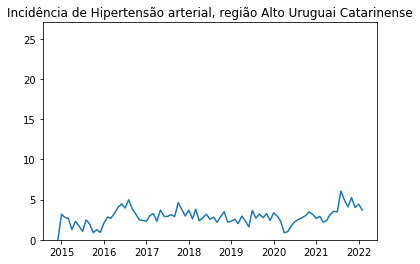

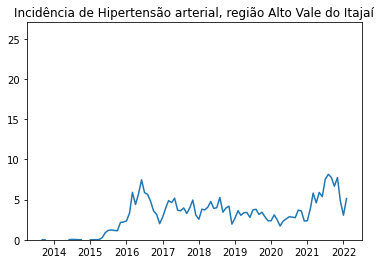

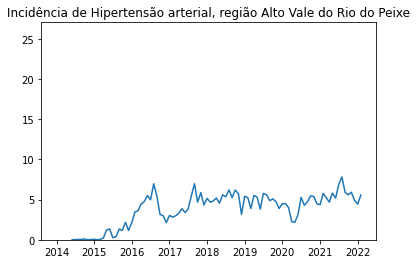

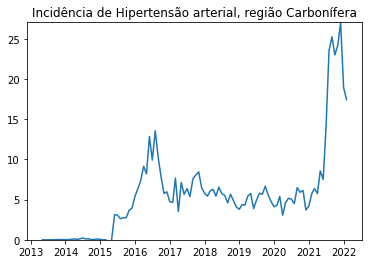

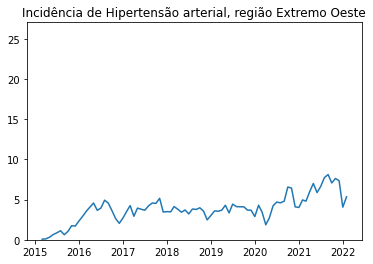

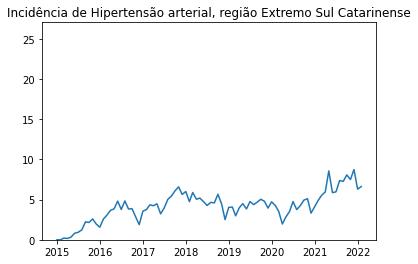

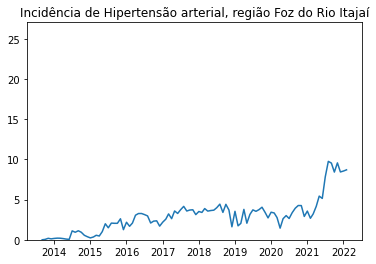

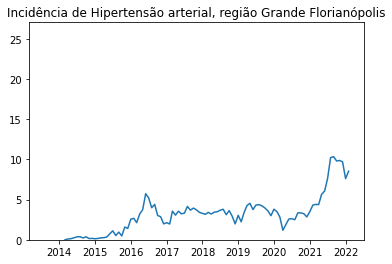

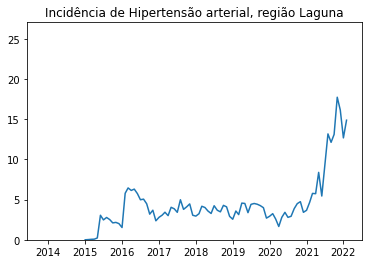

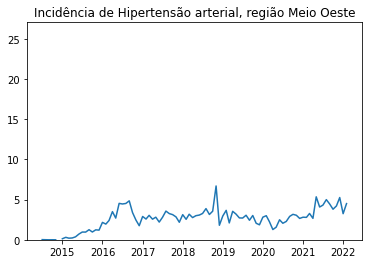

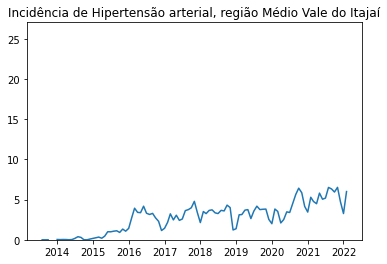

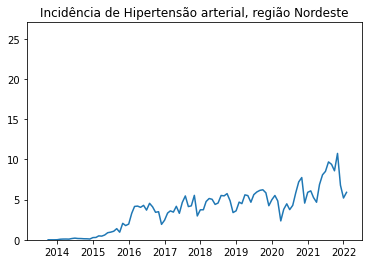

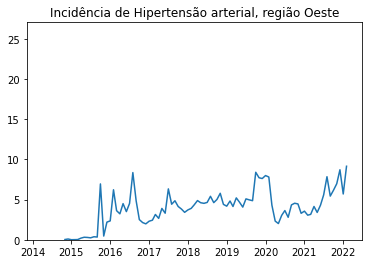

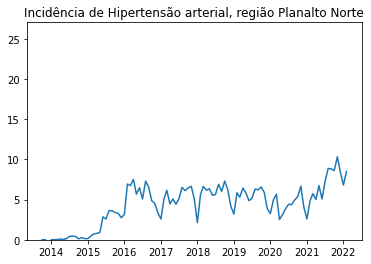

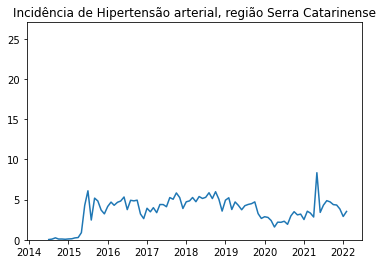

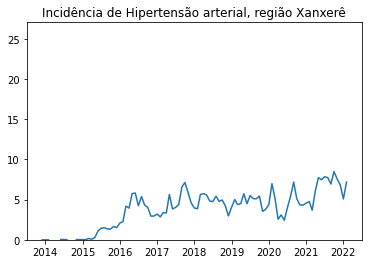

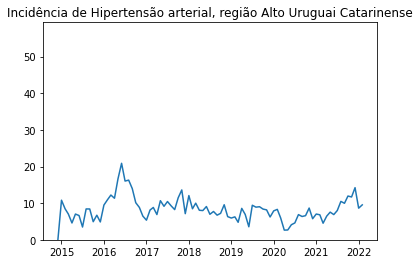

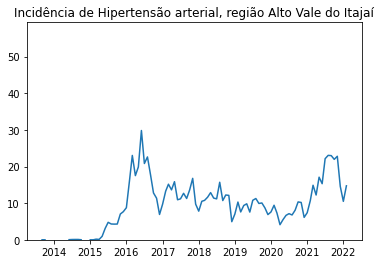

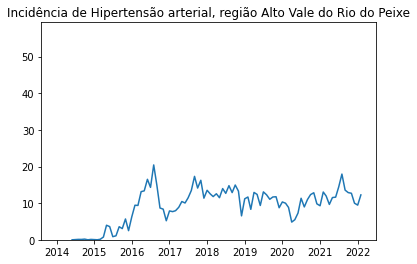

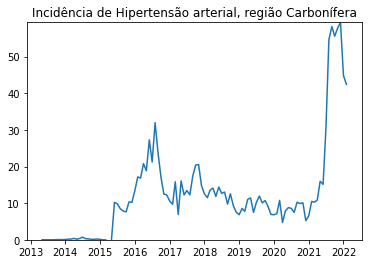

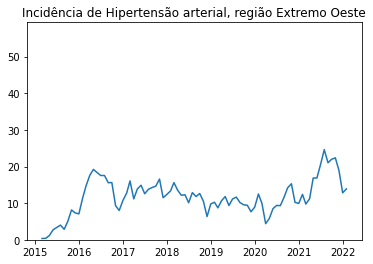

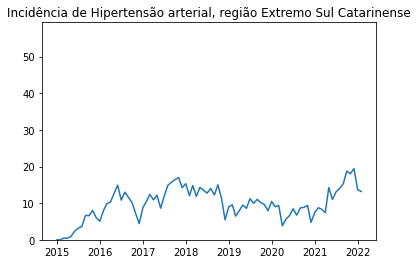

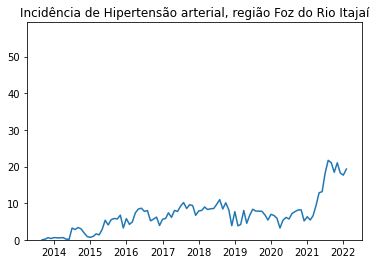

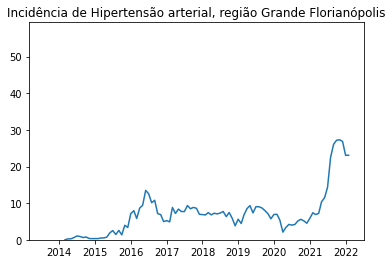

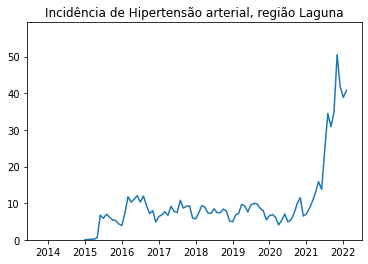

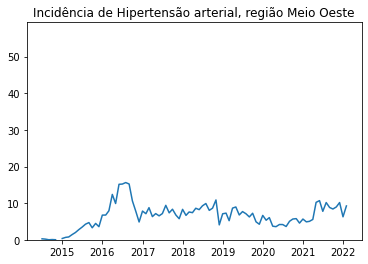

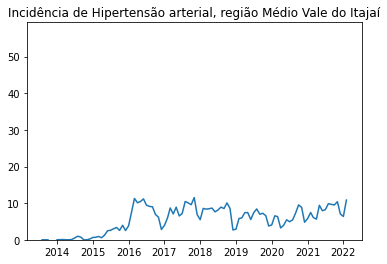

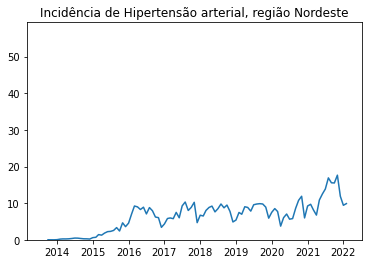

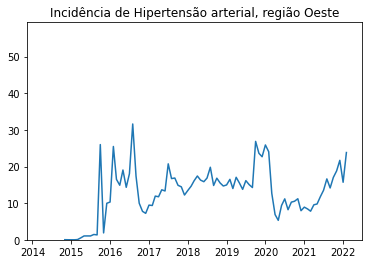

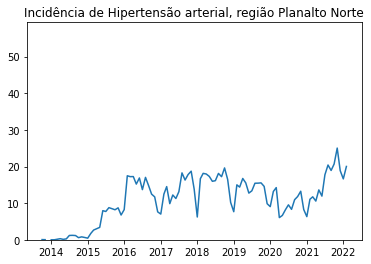

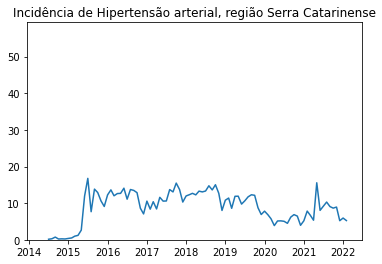

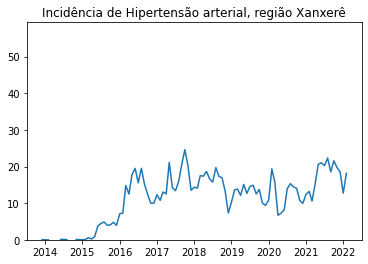

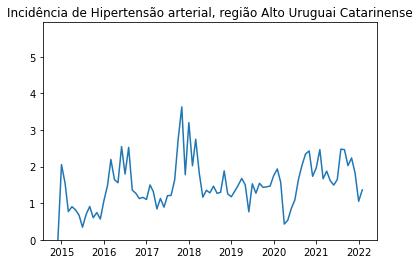

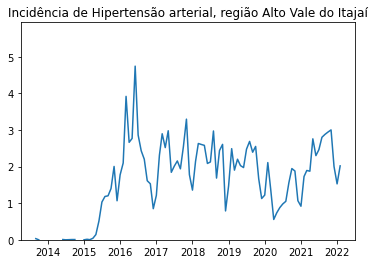

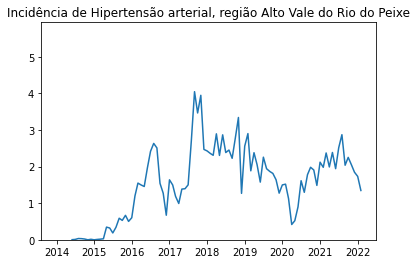

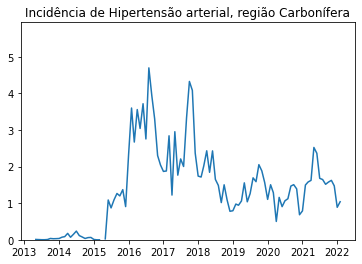

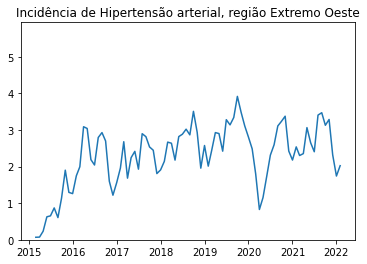

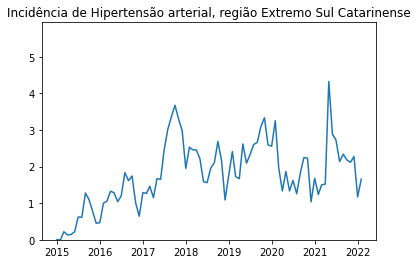

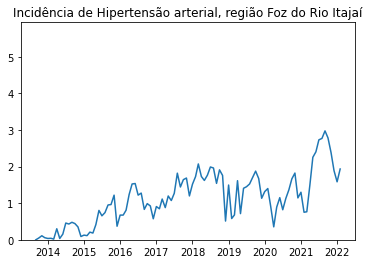

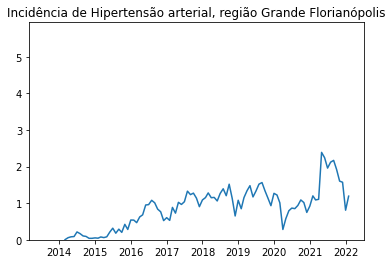

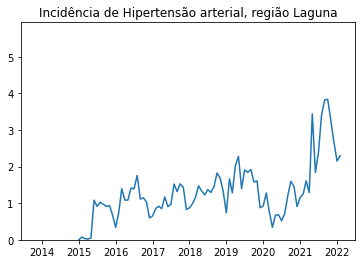

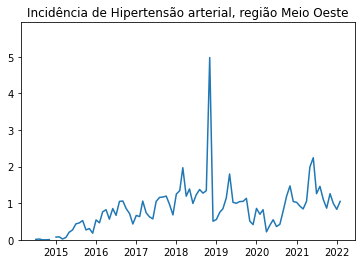

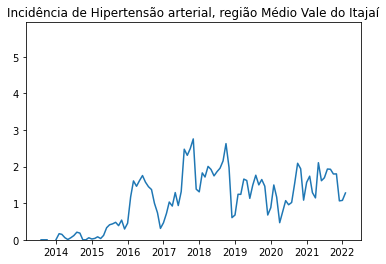

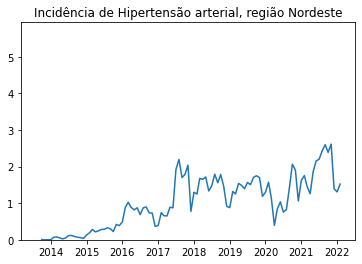

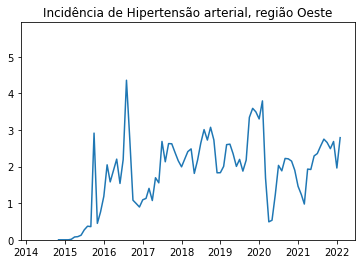

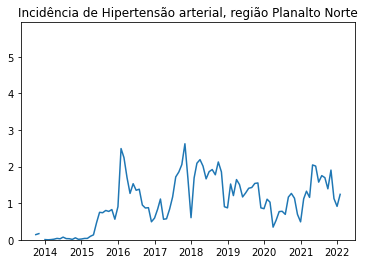

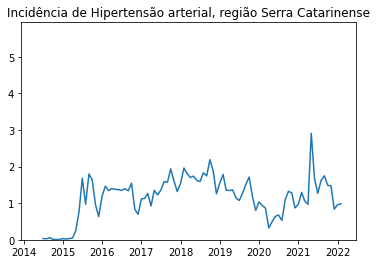

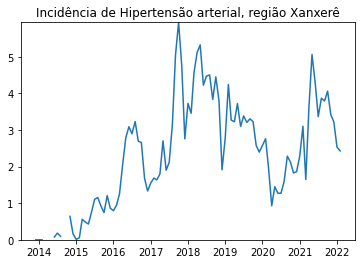

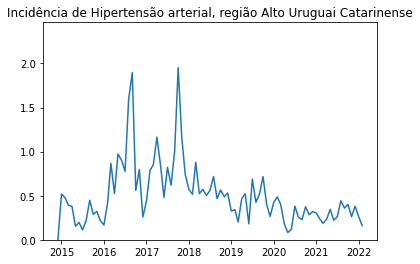

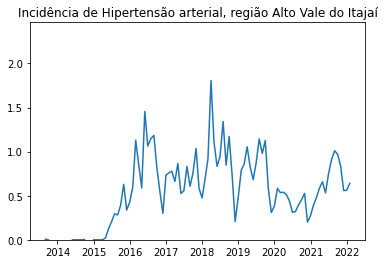

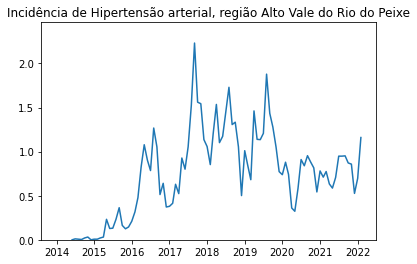

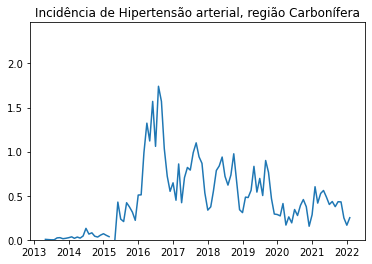

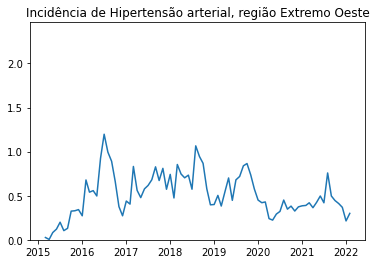

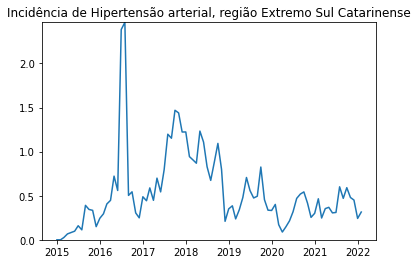

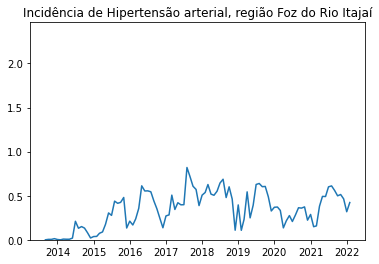

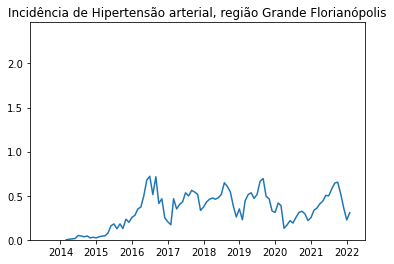

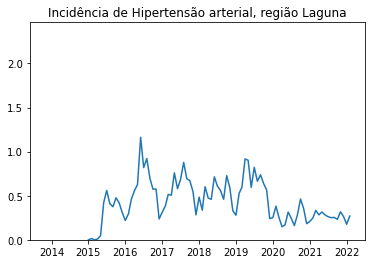

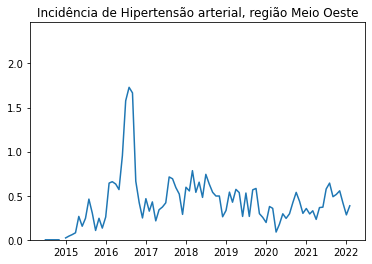

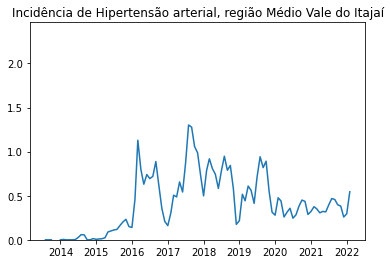

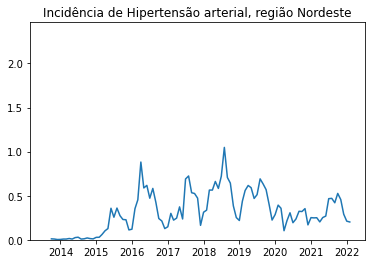

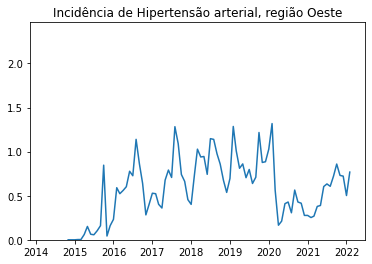

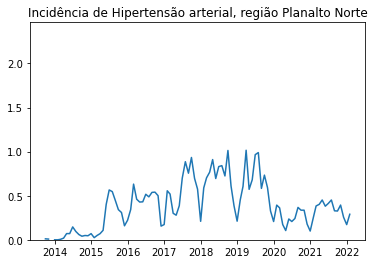

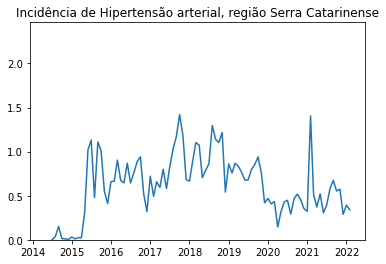

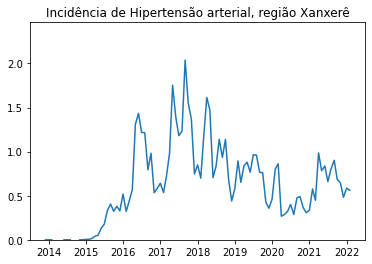

In [107]:
for doenca in doenças_interesse:
    incidencias_regionais = get_indices(doenca)
    ymax = incidencias_regionais.max().max()
    datas = [dt.strptime(str(x), "%Y%m") for x in incidencias_regionais.index.values]

    for x in incidencias_regionais.columns:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.plot(datas, incidencias_regionais[x])
        ax.set_title(f"Incidência de {doença}, região {x}")
        ax.set_ylim((0, ymax))
        fig.savefig(f"graficos/{doença}_{x}.png", dpi=300)
